# Day 12: Model Evaluation - Metrics That Matter

**Welcome to Day 12 of your ML journey!** Today we'll explore one of the most critical skills in machine learning: **Model Evaluation**. Knowing which metrics to use and how to interpret them separates good engineers from great ones. We'll cover everything from confusion matrices to ROC curves, cross-validation, and real-world metric selection strategies.

---

**Goal**: Master the art of evaluating machine learning models using the right metrics for the right problems.

## Why Model Evaluation Matters

Building a model is only half the battle. **Evaluating it correctly** is what separates good engineers from great ones. Using accuracy alone can be misleading, especially with imbalanced datasets. In this notebook, we'll explore:

- **Classification Metrics**: Accuracy, Precision, Recall, F1-Score
- **ROC Curve & AUC**: Understanding model discrimination
- **Precision-Recall Curves**: For imbalanced datasets
- **Cross-Validation**: Getting reliable performance estimates
- **Confusion Matrix**: The foundation of all classification metrics

By the end of this notebook, you'll know exactly which metric to use for any ML problem.


In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification, load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    roc_curve, roc_auc_score, auc,
    precision_recall_curve, average_precision_score
)
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries imported successfully!")


Libraries imported successfully!


---

## Part 1: Understanding the Confusion Matrix

The **confusion matrix** is the foundation of all classification metrics. It shows:

<div align="center">

|           | Predicted |          |
|-----------|-----------|----------|
|           | Negative  | Positive |
| **Actual** |           |          |
| Negative  |     TN    |    FP    |
| Positive  |     FN    |    TP    |

</div>

Where:
- **True Positive (TP)**: Correctly predicted positive
- **True Negative (TN)**: Correctly predicted negative
- **False Positive (FP)**: Incorrectly predicted positive (Type I Error)
- **False Negative (FN)**: Incorrectly predicted negative (Type II Error)

### Real-World Intuition

**Medical Diagnosis Example**:
- **FP (False Positive)**: Telling a healthy patient they have cancer (causes anxiety, unnecessary treatment)
- **FN (False Negative)**: Telling a cancer patient they're healthy (potentially fatal)

Which is worse? It depends on the context.


In [2]:
# Create a simple dataset for demonstration
np.random.seed(42)
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15,
                          n_redundant=5, n_classes=2, weights=[0.7, 0.3],
                          random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a simple logistic regression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("Model trained successfully!")
print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")
print(f"Class distribution in test set: {np.bincount(y_test)}")


Model trained successfully!
Training samples: 700, Test samples: 300
Class distribution in test set: [214  86]


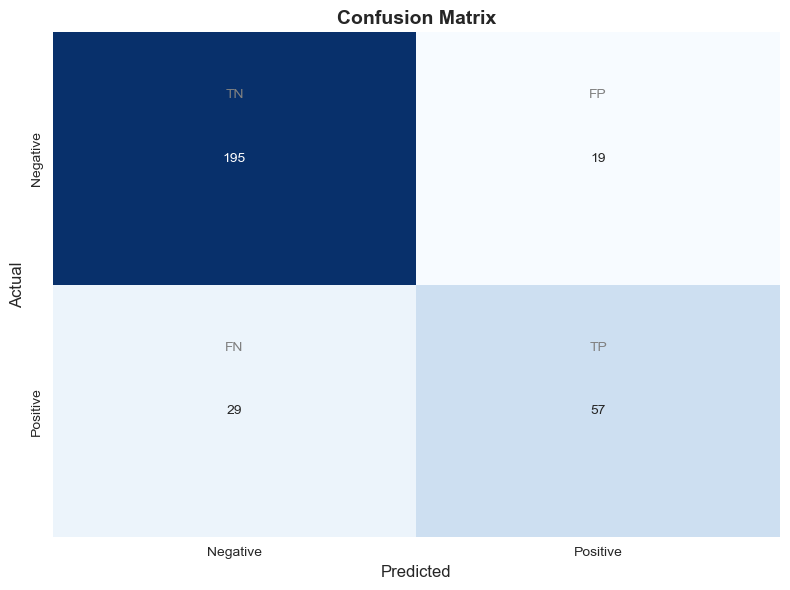

In [3]:
# Visualize confusion matrix
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel('Actual', fontsize=12)
    plt.xlabel('Predicted', fontsize=12)
    
    # Add TN, FP, FN, TP labels
    plt.text(0.5, 0.25, 'TN', ha='center', va='center', fontsize=10, color='gray')
    plt.text(1.5, 0.25, 'FP', ha='center', va='center', fontsize=10, color='gray')
    plt.text(0.5, 1.25, 'FN', ha='center', va='center', fontsize=10, color='gray')
    plt.text(1.5, 1.25, 'TP', ha='center', va='center', fontsize=10, color='gray')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_test, y_pred)


---

## Let's Understand The Above Matrix Chart

So what did you understand? The Above **confusion matrix** is the foundation of all classification metrics. It shows:

<div align="center">

|           | **Predicted Negative** | **Predicted Positive** |
|-----------|------------------------|------------------------|
| **Actual Negative** | **True Negatives (TN): 195** <br> Correctly identified as Negative | **False Positives (FP): 19** <br> Incorrectly flagged as Positive |
| **Actual Positive** | **False Negatives (FN): 29** <br> Missed actual Positives | **True Positives (TP): 57** <br> Correctly identified as Positive |

</div>

**Key Insights:**
- **TN (195)**: Model correctly identified 195 negatives
- **FP (19)**: Model had 19 false alarms (Type I Error)
- **FN (29)**: Model missed 29 positives (Type II Error) 
- **TP (57)**: Model correctly identified 57 positives

**Real-World Intuition:**
**Medical Diagnosis Example**:
- **FP**: Telling a healthy patient they have cancer (causes anxiety, unnecessary treatment)
- **FN**: Telling a cancer patient they're healthy (potentially fatal)

Which is worse? It depends on the context.

--- 
## Wait, What does Type l and Type ll Error Means?

In hypothesis testing, we make decisions based on incomplete information. Sometimes we get it wrong, and these mistakes fall into two categories:

### Type I Error (False Positive)
**Definition**: Rejecting a true null hypothesis

**What it means**: We conclude there's an effect when there actually isn't one.

**Real-World Example - Medical Test**:
- **Situation**: A patient takes a cancer screening test
- **Reality**: The patient is healthy (no cancer)
- **Test Result**: Test says "cancer detected" 
- **Type I Error**: Healthy patient is told they have cancer
- **Consequence**: Unnecessary anxiety, costly treatments, side effects

### Type II Error (False Negative)  
**Definition**: Failing to reject a false null hypothesis

**What it means**: We miss detecting an effect that actually exists.

**Real-World Example - Medical Test**:
- **Situation**: A patient takes a cancer screening test
- **Reality**: The patient has cancer
- **Test Result**: Test says "no cancer detected"
- **Type II Error**: Cancer patient is told they're healthy
- **Consequence**: Delayed treatment, disease progression, potentially fatal

### Quick Comparison

<div align="center">

| Error Type | What Happened | What We Concluded | Real-World Impact |
|------------|---------------|-------------------|-------------------|
| **Type I** | Nothing wrong | Something is wrong | False alarm, unnecessary action |
| **Type II** | Something wrong | Nothing is wrong | Missed opportunity, delayed action |

</div>

### Key Insights

**The Trade-off**:
- Reducing Type I errors increases Type II errors
- Reducing Type II errors increases Type I errors
- We can't minimize both simultaneously

**Which is Worse?**
It depends on the context:
- **Medical diagnosis**: Type II errors are often more dangerous (missing disease)
- **Spam detection**: Type I errors are costly (important emails in spam)
- **Fraud detection**: Type II errors are expensive (missed fraud)

**Statistical Significance Level (α)**:
- Controls the probability of Type I errors
- Common values: α = 0.05 (5% chance of Type I error)
- Lower α = fewer false positives, but more false negatives

### Remember
Both errors have real consequences. The key is understanding your specific situation and choosing an appropriate balance between them.

---

## Part 2: Classification Metrics Explained

### 1. Accuracy

$$ 
Formula = (TP + TN) / (TP + TN + FP + FN)
$$

**Interpretation**: Percentage of correct predictions.

**When to use**: Balanced datasets where all classes are equally important.

**When NOT to use**: Imbalanced datasets (e.g., fraud detection with 99% normal transactions).

---

### 2. Precision

$$
Formula: TP / (TP + FP)
$$
**Interpretation**: Of all positive predictions, how many were actually positive?

**When to use**: When False Positives are costly (e.g., spam detection, drug testing).

**Example**: Email spam filter - you don't want important emails going to spam (FP).

---

### 3. Recall (Sensitivity/True Positive Rate)

$$
Formula: TP / (TP + FN)
$$

**Interpretation**: Of all actual positives, how many did we catch?

**When to use**: When False Negatives are costly (e.g., cancer detection, fraud detection).

**Example**: Cancer screening - missing a cancer case (FN) is worse than a false alarm.

---

### 4. F1-Score

$$
Formula: 2 * (Precision * Recall) / (Precision + Recall)
$$
**Interpretation**: Harmonic mean of Precision and Recall.

**When to use**: Imbalanced datasets, when you need a balance between Precision and Recall.

**Example**: Default metric for many imbalanced classification problems.


In [22]:
# Calculate all metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("=" * 60)
print("\t\tCLASSIFICATION METRICS")
print("=" * 60)
print(f"Accuracy:  {accuracy:.4f}  (Overall correctness)")
print(f"Precision: {precision:.4f}  (Positive predictions accuracy)")
print(f"Recall:    {recall:.4f}  (Caught positive cases)")
print(f"F1-Score:  {f1:.4f}  (Harmonic mean of P & R)")
print("=" * 60)


		CLASSIFICATION METRICS
Accuracy:  0.8400  (Overall correctness)
Precision: 0.7500  (Positive predictions accuracy)
Recall:    0.6628  (Caught positive cases)
F1-Score:  0.7037  (Harmonic mean of P & R)


In [5]:
# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))



Detailed Classification Report:
              precision    recall  f1-score   support

     Class 0       0.87      0.91      0.89       214
     Class 1       0.75      0.66      0.70        86

    accuracy                           0.84       300
   macro avg       0.81      0.79      0.80       300
weighted avg       0.84      0.84      0.84       300



---

## Quick Quiz: Interpreting Classification Reports

Let's test your understanding of this classification report!

### Question 1: Imbalance Impact
Looking at the support values (Class 0: 214 samples, Class 1: 86 samples), which average (Macro Avg or Weighted Avg) provides a more optimistic view of the model's overall performance? Why might this be misleading in certain scenarios?

👉 **Your Answer:** ___

### Question 2: Targeted Improvement
If the business objective is to minimize "missed detections" for Class 1 (reduce False Negatives), which specific metric for Class 1 should you focus on? What does its current value (0.66) suggest about the model's performance?

👉 **Your Answer:** ___

### Bonus Question: Strategic Decision
Given that Class 1 has lower recall (0.66) than Class 0 (0.91), what would you recommend to improve the model's performance on Class 1 specifically?

👉 **Your Answer:** ___

---

**Think about it:** The weighted average is higher than the macro average here. What does this tell you about the model's bias?

---

## Part 3: The Precision-Recall Trade-off

There's always a **trade-off** between Precision and Recall:

- **Higher Threshold** → Higher Precision, Lower Recall (fewer predictions, but more confident)
- **Lower Threshold** → Lower Precision, Higher Recall (more predictions, catch more positives)

### Decision Threshold Tuning

By default, classifiers use a threshold of **0.5** for binary classification. But you can adjust this based on your needs.


In [6]:
# Demonstrate threshold impact
thresholds = [0.3, 0.5, 0.7, 0.9]
results = []

for threshold in thresholds:
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)
    prec = precision_score(y_test, y_pred_threshold, zero_division=0)
    rec = recall_score(y_test, y_pred_threshold)
    f1 = f1_score(y_test, y_pred_threshold, zero_division=0)
    results.append({
        'Threshold': threshold,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })

results_df = pd.DataFrame(results)
print("\nImpact of Classification Threshold:")
print(results_df.to_string(index=False))



Impact of Classification Threshold:
 Threshold  Precision   Recall  F1-Score
       0.3   0.642857 0.837209  0.727273
       0.5   0.750000 0.662791  0.703704
       0.7   0.826923 0.500000  0.623188
       0.9   0.956522 0.255814  0.403670


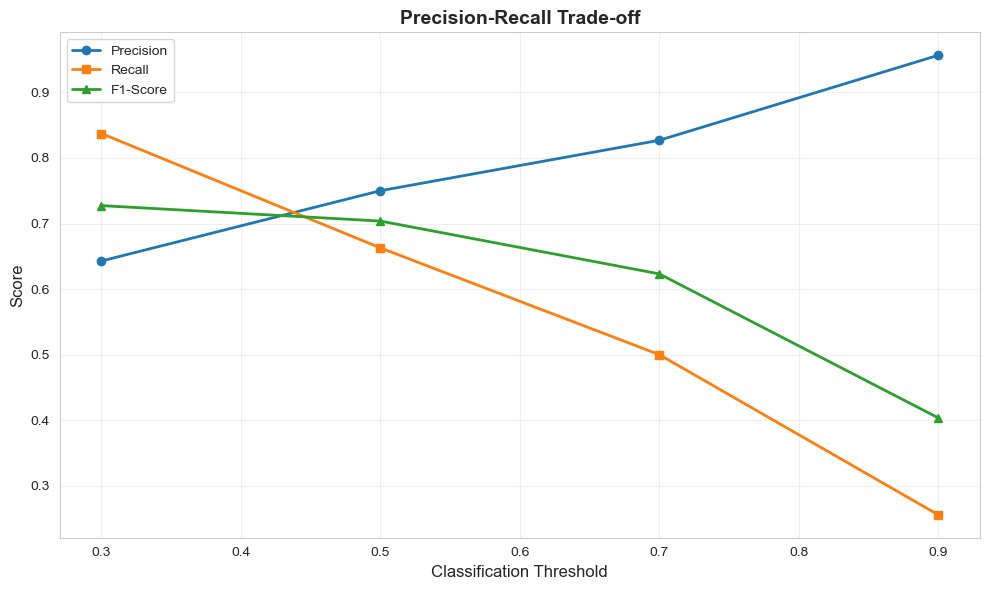

In [7]:
# Visualize the trade-off
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(results_df['Threshold'], results_df['Precision'], marker='o', label='Precision', linewidth=2)
ax.plot(results_df['Threshold'], results_df['Recall'], marker='s', label='Recall', linewidth=2)
ax.plot(results_df['Threshold'], results_df['F1-Score'], marker='^', label='F1-Score', linewidth=2)
ax.set_xlabel('Classification Threshold', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Precision-Recall Trade-off', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


---

## Understanding the Precision-Recall Trade-off

This chart reveals one of the most fundamental concepts in machine learning: the **inverse relationship** between Precision and Recall as we adjust our classification threshold.

### What the Graph Shows

The chart displays three key metrics plotted against the **Classification Threshold**:

- **X-axis**: Classification Threshold (0.3 to 0.9)
- **Y-axis**: Score values (0.0 to 1.0)
- **Three lines**: Precision (blue), Recall (orange), F1-Score (green)

### Key Relationships and Patterns

#### Precision Trend
- **Pattern**: Steadily **increases** as threshold rises
- **Explanation**: Higher thresholds make the model more conservative, reducing false positives
- **Values**: Rises from ~0.64 (at 0.3) to ~0.95 (at 0.9)
- **Practical meaning**: At higher thresholds, when the model predicts positive, it's usually right

#### Recall Trend  
- **Pattern**: Steadily **decreases** as threshold rises
- **Explanation**: Higher thresholds make the model miss more actual positives
- **Values**: Drops from ~0.84 (at 0.3) to ~0.25 (at 0.9)
- **Practical meaning**: At higher thresholds, the model catches fewer of the actual positive cases

#### F1-Score Pattern
- **Pattern**: **Decreases** as threshold increases
- **Peak performance**: Best F1-score occurs at the lowest threshold (0.3)
- **Meaning**: The harmonic mean of Precision and Recall, providing a balanced view

### The Critical Trade-off

**The Inverse Relationship**: This is the core insight - you cannot simultaneously maximize both Precision and Recall. They move in opposite directions:

- **Low Threshold (0.3)**: High Recall, Lower Precision
  - Catches most positive cases but has more false alarms
  - Good when missing positives is costly (e.g., cancer detection)

- **High Threshold (0.9)**: High Precision, Lower Recall  
  - Few false alarms but misses many positive cases
  - Good when false positives are costly (e.g., spam detection)

### Why This Matters for Data Science

#### 1. Business Decision Making
The optimal threshold depends on your specific costs:
- **Medical diagnosis**: Prioritize Recall (don't miss diseases)
- **Email spam**: Prioritize Precision (don't flag important emails)
- **Fraud detection**: Balance both, but missing fraud is often more expensive

#### 2. Model Evaluation Beyond Accuracy
A single accuracy score doesn't reveal this trade-off. This chart shows:
- How sensitive your model is to threshold changes
- Whether your model has consistent performance across thresholds
- Where to set the threshold for optimal business outcomes

#### 3. Feature Engineering Insights
If the trade-off is poor across all thresholds:
- Your features may not be discriminative enough
- Consider collecting more relevant data
- Try different algorithms or ensemble methods

#### 4. Threshold Selection Strategy
- **Use F1-Score curve**: Find the threshold that maximizes F1-Score for balanced performance
- **Use Precision-Recall curves**: Choose based on your specific cost structure
- **Validate on hold-out data**: Don't optimize threshold on the same data used for training

### Key Takeaways

1. **No Free Lunch**: Improving one metric often hurts the other
2. **Context Matters**: The "best" threshold depends on your business problem
3. **Visual Understanding**: This chart provides insights that numbers alone cannot convey
4. **Actionable Insights**: Use this analysis to make informed decisions about model deployment

The precision-recall trade-off is not a limitation but a fundamental property of classification that, when understood properly, enables better decision-making in real-world applications.

---

## Part 4: ROC Curve & AUC Score

### What is ROC?

**ROC (Receiver Operating Characteristic)** curve plots:
- **X-axis**: False Positive Rate (FPR) = FP / (FP + TN)
- **Y-axis**: True Positive Rate (TPR) = Recall = TP / (TP + FN)

### What is AUC?

**AUC (Area Under the Curve)** measures the entire area under the ROC curve:
- **AUC = 1.0**: Perfect classifier
- **AUC = 0.5**: Random guessing (baseline)
- **AUC < 0.5**: Worse than random (model is backwards)

### When to Use ROC-AUC?

- **Use ROC-AUC** when you want to evaluate model's ability to distinguish between classes
- **Balanced datasets** or when both classes are important
- **Comparing different models** at various thresholds

### When NOT to Use ROC-AUC?

- **Highly imbalanced datasets** - can be overly optimistic
- When False Positives and False Negatives have very different costs
- Use **Precision-Recall curve** instead for imbalanced data


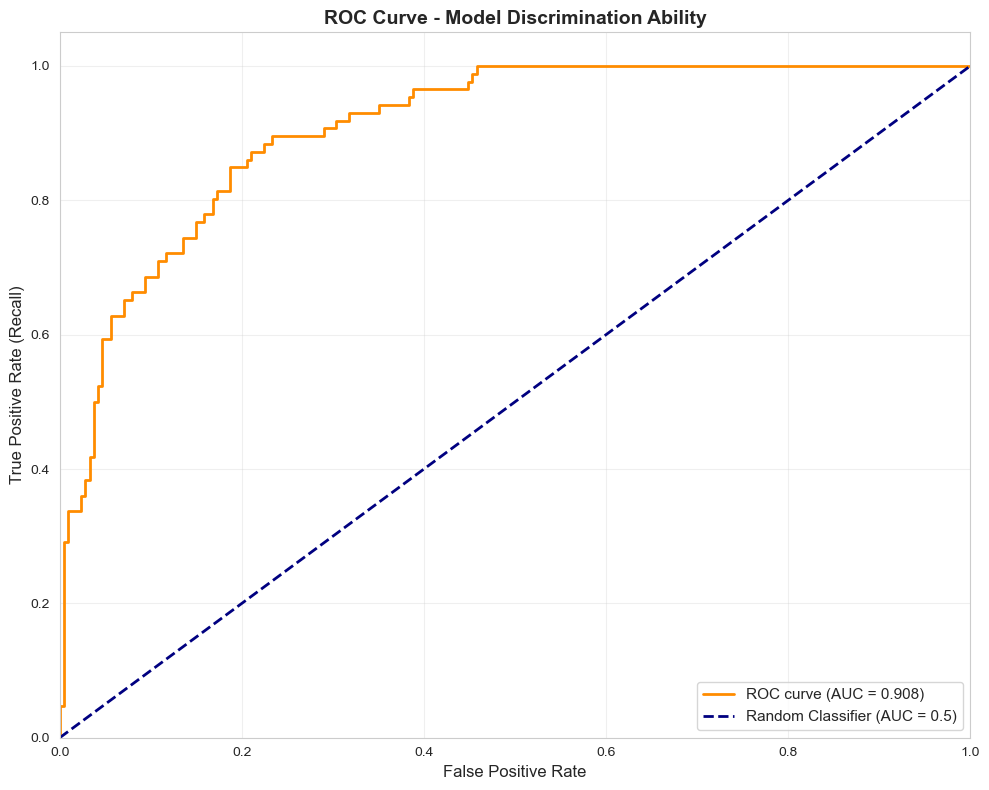


AUC Score: 0.9077
Interpretation: Model has good discrimination ability.


In [8]:
# Calculate ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('ROC Curve - Model Discrimination Ability', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nAUC Score: {roc_auc:.4f}")
print("Interpretation: Model has good discrimination ability.")


---

## Understanding the ROC Curve: Model Discrimination Ability

This chart, known as a **Receiver Operating Characteristic (ROC) curve**, is a powerful tool for evaluating the performance of a classification model, particularly its ability to distinguish between positive and negative classes across various classification thresholds.

### What the Graph Shows

The graph plots two key metrics against each other:

*   **X-axis: False Positive Rate (FPR)**
    *   This represents the proportion of actual negative cases that were incorrectly identified as positive. It's calculated as `FP / (FP + TN)`.
*   **Y-axis: True Positive Rate (TPR) or Recall**
    *   This represents the proportion of actual positive cases that were correctly identified as positive. It's calculated as `TP / (TP + FN)`.

The chart features two distinct lines:

*   **Orange Line: The ROC Curve of the Model**
    *   This curve represents our model's performance. As we move along this curve from left to right, we are effectively lowering the classification threshold.
    *   It has an **Area Under the Curve (AUC) of 0.908**.
*   **Dashed Dark Blue Line: Random Classifier**
    *   This diagonal line represents a model that performs no better than random guessing.
    *   It has an **AUC of 0.5**.

### Key Relationships and Patterns

*   **Nonlinear Relationship**: The orange ROC curve shows a nonlinear relationship between the True Positive Rate and the False Positive Rate. Ideally, we want a high True Positive Rate with a low False Positive Rate.
*   **Strong Discrimination**: The orange ROC curve is significantly bowed towards the top-left corner of the plot, indicating a **strong ability** of the model to discriminate between positive and negative classes.
    *   It rises steeply, meaning the model can achieve a high True Positive Rate (e.g., around 0.9) while maintaining a relatively low False Positive Rate (e.g., below 0.2).
    *   The curve then flattens out, suggesting that further increases in True Positive Rate come at a higher cost of False Positive Rate.
*   **Comparison to Random**: The model's ROC curve is far above the dashed blue "Random Classifier" line. This is a positive sign, as any useful model should perform better than random chance.
*   **Area Under the Curve (AUC)**:
    *   The AUC value of **0.908** for our model is very high (AUC ranges from 0 to 1). An AUC of 1.0 represents a perfect classifier, while 0.5 represents a random classifier.
    *   This high AUC indicates that the model has excellent discriminatory power; it can distinguish between positive and negative classes very well.

### Why These Observations Are Important for Data Science/ML

*   **Model Evaluation**: The ROC curve and its AUC are crucial for evaluating the overall performance of a classification model, especially when dealing with imbalanced datasets where accuracy alone can be misleading.
*   **Threshold Selection**: The curve helps in understanding the trade-off between sensitivity (True Positive Rate) and specificity (1 - False Positive Rate). Data scientists can use this to select an optimal classification threshold based on the specific business problem and the costs associated with Type I (false positive) and Type II (false negative) errors. For instance, if false positives are very costly, one might choose a threshold that keeps FPR very low, even if it slightly reduces TPR.
*   **Model Comparison**: ROC curves and AUC scores provide a robust way to compare different models. A model with a higher AUC is generally considered better at distinguishing between classes.
*   **Predictive Power**: A high AUC (like 0.908 here) suggests that the features used in the model have strong predictive power for the target variable, making the model reliable for its classification task. This insight can guide further feature engineering or model refinement.

In summary, this ROC curve clearly demonstrates that our model is a highly effective classifier with strong discriminatory ability, performing significantly better than random chance.

---

## Part 5: Precision-Recall Curve

### Why Precision-Recall over ROC?

**Precision-Recall (PR) curves** are better for **imbalanced datasets** because:
- ROC curves can be overly optimistic when negatives dominate
- PR curves focus on the positive class performance
- More informative when you care about the minority class

### Average Precision (AP)

Similar to AUC but for PR curve. Higher is better.

### Real-World Use Cases:
- Fraud detection (1% fraud cases)
- Medical diagnosis (rare diseases)
- Anomaly detection
- Information retrieval


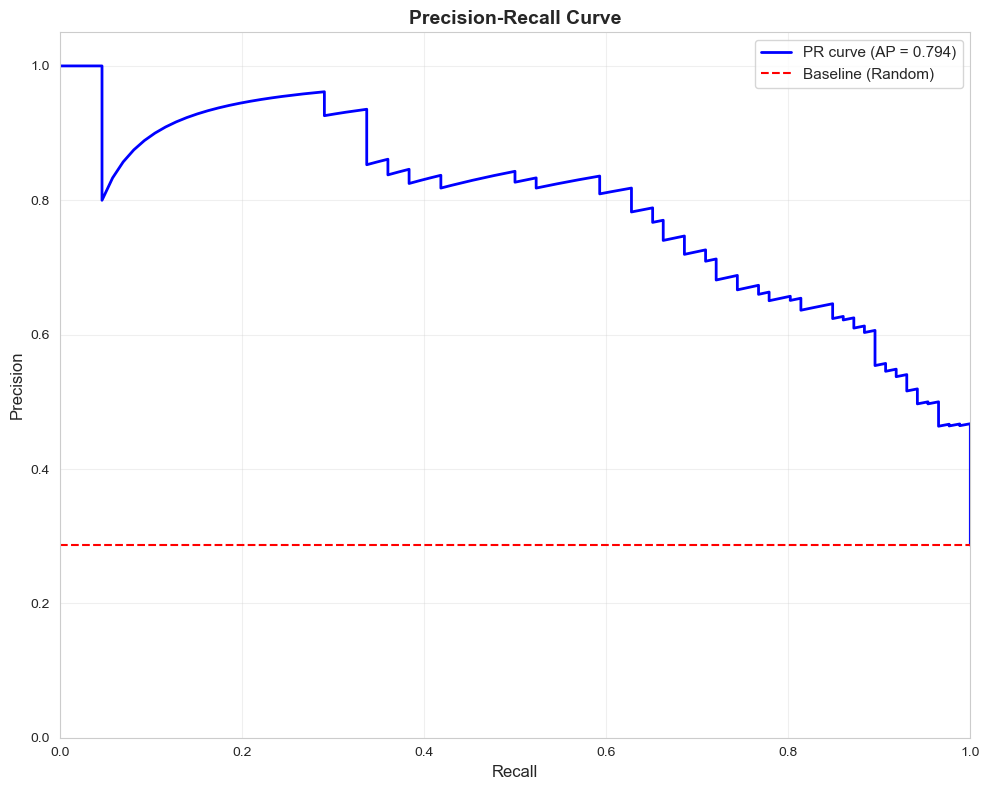


Average Precision Score: 0.7940
Interpretation: Good performance on positive class.


In [9]:
# Calculate Precision-Recall curve
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

# Plot Precision-Recall curve
plt.figure(figsize=(10, 8))
plt.plot(recall_curve, precision_curve, color='blue', lw=2, 
         label=f'PR curve (AP = {avg_precision:.3f})')
plt.axhline(y=y_test.sum()/len(y_test), color='red', linestyle='--', 
           label='Baseline (Random)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend(loc="best", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nAverage Precision Score: {avg_precision:.4f}")
print("Interpretation: Good performance on positive class.")


---

## Let's Understanding the Precision-Recall Curve: A Deeper Look at Model Performance

Alright, we’ve learned a lot so far. Don’t get tired just yet things might look a bit confusing, but stick with me.

Now, take a look at this chart: the Precision-Recall (PR) Curve.
It’s a powerful tool for evaluating classification models, especially when your dataset is imbalanced where one class is much rarer than the other.

### What the Graph Shows

The graph plots two fundamental metrics against each other:

*   **X-axis: Recall**
    *   This represents the proportion of actual positive cases that the model correctly identified. It's also known as **True Positive Rate (TPR)** or **Sensitivity**.
    *   A higher recall means the model is catching more of the true positives.
*   **Y-axis: Precision**
    *   This represents the proportion of positive predictions made by the model that were actually correct.
    *   A higher precision means the model has fewer false positive errors.
*   **Blue Line: PR curve (AP = 0.794)**
    *   This line illustrates how the model's precision changes as its recall changes, typically by adjusting the classification threshold.
    *   The **Average Precision (AP)** value of 0.794 is a single-number summary of the curve, representing the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight. It's essentially the area under the PR curve.
*   **Red Dashed Line: Baseline (Random)**
    *   This horizontal line indicates the precision that a random classifier would achieve. In this case, it's approximately 0.29. A good model should always perform significantly above this baseline.

### Key Relationships and Patterns

*   **Inverse Relationship (Trade-off):** The most prominent feature is the non-linear, generally inverse relationship between Precision and Recall.
    *   At very low recall (left side of the graph), the model often achieves high precision (close to 1.0). This means it's very confident in its few positive predictions, but it's missing many actual positive cases.
    *   As recall increases (moving right along the X-axis), the model attempts to identify more positive cases. To do this, it often has to lower its classification threshold, which can lead to more false positives and, consequently, a drop in precision.
    *   The curve shows a sharp initial drop in precision as recall increases from 0, then a rise to a peak around 0.95 precision at 0.25 recall, followed by a gradual, stepped decline as recall approaches 1.0.
*   **Stepped Nature:** The PR curve often appears "stepped" because precision and recall values only change at specific classification thresholds where the model's predictions flip for certain data points.
*   **Model Performance:** The blue PR curve is significantly above the red random baseline, indicating that the model has strong predictive power and is much better than guessing. An AP of 0.794 suggests a reasonably good performance for this model.

### Why These Observations Are Important for Data Science/ML

*   **Model Selection and Comparison:** The PR curve and Average Precision are excellent metrics for comparing different models, especially in scenarios with class imbalance. A model with a PR curve that is higher and further to the right (enclosing a larger area) is generally better.
*   **Threshold Optimization:** The curve helps in selecting an optimal classification threshold based on the specific problem's requirements.
    *   If **False Positives are very costly** (e.g., flagging a healthy person with a serious disease), you might choose a threshold that prioritizes **high precision** (left side of the curve), even if it means lower recall.
    *   If **False Negatives are very costly** (e.g., missing a fraudulent transaction or a dangerous disease), you might choose a threshold that prioritizes **high recall** (right side of the curve), accepting a lower precision.
*   **Understanding Model Strengths and Weaknesses:** The shape of the curve provides insights into where the model performs well and where it struggles. For instance, if the curve drops sharply early, it means the model quickly starts making many false positive errors as it tries to capture more true positives.
*   **Beyond Accuracy:** Unlike accuracy, which can be misleading on imbalanced datasets, the PR curve provides a

---

## Part 6: Cross-Validation - The Gold Standard

### Why Cross-Validation?

A single train-test split can be **misleading** due to:
- Lucky/unlucky splits
- Variance in performance estimates
- Not utilizing all data for validation

### K-Fold Cross-Validation

1. Split data into K folds (typically 5 or 10)
2. Train on K-1 folds, validate on 1 fold
3. Repeat K times, rotating validation fold
4. Average the results

### Stratified K-Fold

**Stratified** maintains class distribution in each fold - crucial for imbalanced data.

### When to Use Each?

- **K-Fold**: Regression, balanced classification
- **Stratified K-Fold**: Classification (especially imbalanced)
- **Leave-One-Out**: Small datasets (computationally expensive)
- **Time Series Split**: Temporal data (no shuffling)


In [23]:
# Standard K-Fold Cross-Validation
print("=" * 60)
print("\t\tCROSS-VALIDATION RESULTS")
print("=" * 60)

# Accuracy scores
cv_scores_acc = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(f"\nAccuracy - 5-Fold CV:")
print(f"  Scores: {cv_scores_acc}")
print(f"  Mean: {cv_scores_acc.mean():.4f} (+/- {cv_scores_acc.std() * 2:.4f})")

# F1 scores
cv_scores_f1 = cross_val_score(model, X, y, cv=5, scoring='f1')
print(f"\nF1-Score - 5-Fold CV:")
print(f"  Scores: {cv_scores_f1}")
print(f"  Mean: {cv_scores_f1.mean():.4f} (+/- {cv_scores_f1.std() * 2:.4f})")

# ROC-AUC scores
cv_scores_auc = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
print(f"\nROC-AUC - 5-Fold CV:")
print(f"  Scores: {cv_scores_auc}")
print(f"  Mean: {cv_scores_auc.mean():.4f} (+/- {cv_scores_auc.std() * 2:.4f})")
print("=" * 60)


		CROSS-VALIDATION RESULTS

Accuracy - 5-Fold CV:
  Scores: [0.81  0.855 0.83  0.815 0.835]
  Mean: 0.8290 (+/- 0.0319)

F1-Score - 5-Fold CV:
  Scores: [0.64150943 0.74336283 0.69642857 0.67256637 0.68571429]
  Mean: 0.6879 (+/- 0.0666)

ROC-AUC - 5-Fold CV:
  Scores: [0.87666667 0.88380952 0.90345238 0.84178571 0.90222904]
  Mean: 0.8816 (+/- 0.0449)


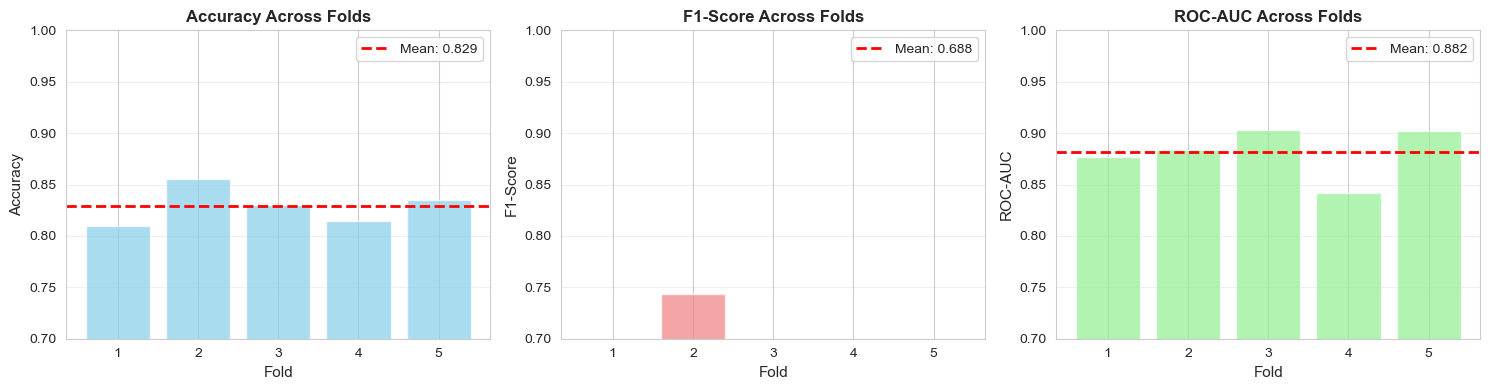

In [11]:
# Visualize CV scores
cv_results = pd.DataFrame({
    'Fold': range(1, 6),
    'Accuracy': cv_scores_acc,
    'F1-Score': cv_scores_f1,
    'ROC-AUC': cv_scores_auc
})

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
metrics = ['Accuracy', 'F1-Score', 'ROC-AUC']
colors = ['skyblue', 'lightcoral', 'lightgreen']

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    axes[idx].bar(cv_results['Fold'], cv_results[metric], color=color, alpha=0.7)
    axes[idx].axhline(y=cv_results[metric].mean(), color='red', linestyle='--', 
                     linewidth=2, label=f'Mean: {cv_results[metric].mean():.3f}')
    axes[idx].set_xlabel('Fold', fontsize=11)
    axes[idx].set_ylabel(metric, fontsize=11)
    axes[idx].set_title(f'{metric} Across Folds', fontsize=12, fontweight='bold')
    axes[idx].legend()
    axes[idx].set_ylim([0.7, 1.0])
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


In [12]:
# Stratified K-Fold for imbalanced data
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
stratified_scores = cross_val_score(model, X, y, cv=skf, scoring='f1')

print("\nStratified K-Fold (maintains class distribution):")
print(f"F1 Scores: {stratified_scores}")
print(f"Mean F1: {stratified_scores.mean():.4f} (+/- {stratified_scores.std() * 2:.4f})")



Stratified K-Fold (maintains class distribution):
F1 Scores: [0.66666667 0.61538462 0.7047619  0.77876106 0.68965517]
Mean F1: 0.6910 (+/- 0.1066)


---

## Part 7: Let's Practice on Real-World Example - Breast Cancer Detection

Let's apply everything we've learned to a real medical dataset where:
- **False Negatives** (missing cancer) are very costly
- We need high **Recall** to catch most cancer cases
- But also maintain reasonable **Precision** to avoid unnecessary biopsies


In [13]:
# Load breast cancer dataset
data = load_breast_cancer()
X_cancer = data.data
y_cancer = data.target  # 1 = benign (healthy), 0 = malignant (cancer)

# Note: We'll flip labels so 1 = cancer (positive class)
y_cancer = 1 - y_cancer

print("Breast Cancer Dataset Loaded")
print(f"Samples: {len(y_cancer)}")
print(f"Features: {X_cancer.shape[1]}")
print(f"\nClass Distribution:")
print(f"  Cancer (1): {np.sum(y_cancer)} ({np.sum(y_cancer)/len(y_cancer)*100:.1f}%)")
print(f"  Healthy (0): {len(y_cancer) - np.sum(y_cancer)} ({(1-np.sum(y_cancer)/len(y_cancer))*100:.1f}%)")


Breast Cancer Dataset Loaded
Samples: 569
Features: 30

Class Distribution:
  Cancer (1): 212 (37.3%)
  Healthy (0): 357 (62.7%)


In [14]:
# Split data
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_cancer, y_cancer, test_size=0.2, random_state=42, stratify=y_cancer
)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_c, y_train_c)

# Predictions
y_pred_c = rf_model.predict(X_test_c)
y_pred_proba_c = rf_model.predict_proba(X_test_c)[:, 1]

print("Model trained successfully!")


Model trained successfully!


In [25]:
# Comprehensive evaluation
print("=" * 70)
print("\t\tBREAST CANCER DETECTION - MODEL EVALUATION")
print("=" * 70)

print("\nClassification Report:")
print(classification_report(y_test_c, y_pred_c, target_names=['Healthy', 'Cancer']))

print("\nConfusion Matrix Analysis:")
tn, fp, fn, tp = confusion_matrix(y_test_c, y_pred_c).ravel()
print(f"  True Negatives (Healthy correctly identified):  {tn}")
print(f"  False Positives (Healthy wrongly flagged):      {fp}")
print(f"  False Negatives (Cancer MISSED - CRITICAL):     {fn}")
print(f"  True Positives (Cancer correctly detected):     {tp}")

print("\nKey Metrics:")
print(f"  Recall (Cancer Detection Rate): {recall_score(y_test_c, y_pred_c):.4f}")
print(f"  Precision (Cancer Prediction Accuracy): {precision_score(y_test_c, y_pred_c):.4f}")
print(f"  F1-Score: {f1_score(y_test_c, y_pred_c):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_test_c, y_pred_proba_c):.4f}")
print("=" * 70)


		BREAST CANCER DETECTION - MODEL EVALUATION

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.96      1.00      0.98        72
      Cancer       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114


Confusion Matrix Analysis:
  True Negatives (Healthy correctly identified):  72
  False Positives (Healthy wrongly flagged):      0
  False Negatives (Cancer MISSED - CRITICAL):     3
  True Positives (Cancer correctly detected):     39

Key Metrics:
  Recall (Cancer Detection Rate): 0.9286
  Precision (Cancer Prediction Accuracy): 1.0000
  F1-Score: 0.9630
  ROC-AUC: 0.9929


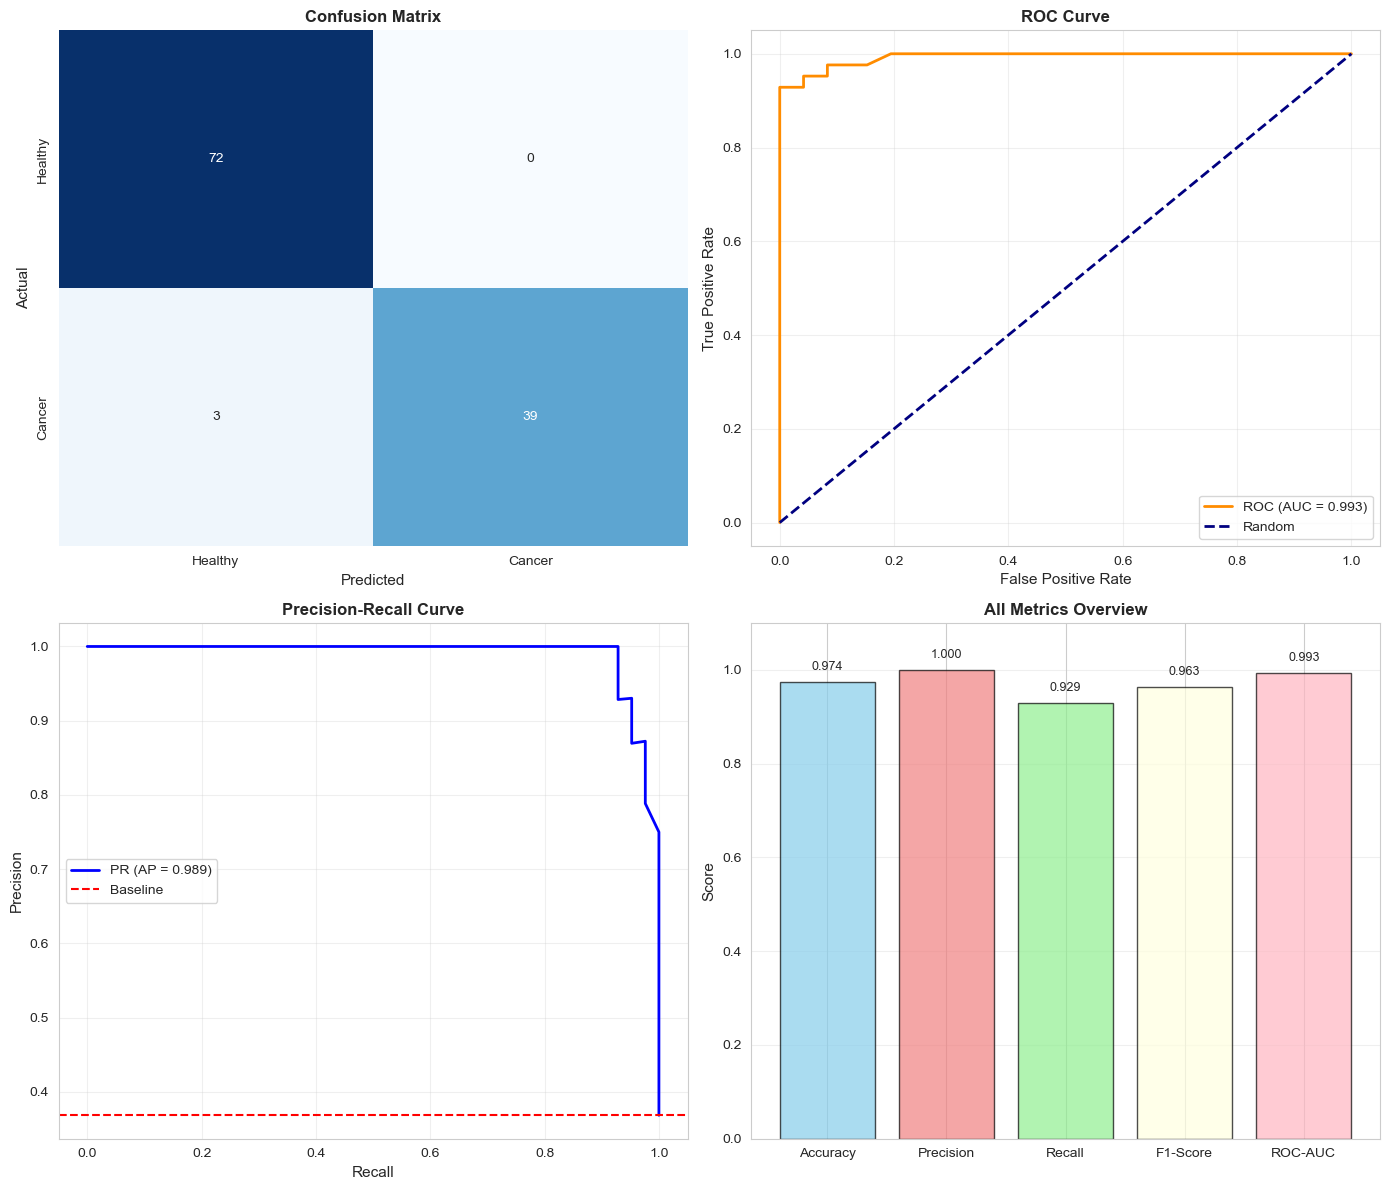

In [16]:
# Visualize comprehensive metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Confusion Matrix
cm = confusion_matrix(y_test_c, y_pred_c)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0, 0],
           xticklabels=['Healthy', 'Cancer'],
           yticklabels=['Healthy', 'Cancer'])
axes[0, 0].set_title('Confusion Matrix', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Actual', fontsize=11)
axes[0, 0].set_xlabel('Predicted', fontsize=11)

# 2. ROC Curve
fpr_c, tpr_c, _ = roc_curve(y_test_c, y_pred_proba_c)
roc_auc_c = auc(fpr_c, tpr_c)
axes[0, 1].plot(fpr_c, tpr_c, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc_c:.3f})')
axes[0, 1].plot([0, 1], [0, 1], 'navy', lw=2, linestyle='--', label='Random')
axes[0, 1].set_xlabel('False Positive Rate', fontsize=11)
axes[0, 1].set_ylabel('True Positive Rate', fontsize=11)
axes[0, 1].set_title('ROC Curve', fontsize=12, fontweight='bold')
axes[0, 1].legend(loc='lower right')
axes[0, 1].grid(True, alpha=0.3)

# 3. Precision-Recall Curve
prec_c, rec_c, _ = precision_recall_curve(y_test_c, y_pred_proba_c)
ap_c = average_precision_score(y_test_c, y_pred_proba_c)
axes[1, 0].plot(rec_c, prec_c, color='blue', lw=2, label=f'PR (AP = {ap_c:.3f})')
axes[1, 0].axhline(y=y_test_c.sum()/len(y_test_c), color='red', linestyle='--', label='Baseline')
axes[1, 0].set_xlabel('Recall', fontsize=11)
axes[1, 0].set_ylabel('Precision', fontsize=11)
axes[1, 0].set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
axes[1, 0].legend(loc='best')
axes[1, 0].grid(True, alpha=0.3)

# 4. Metrics Comparison
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
metrics_values = [
    accuracy_score(y_test_c, y_pred_c),
    precision_score(y_test_c, y_pred_c),
    recall_score(y_test_c, y_pred_c),
    f1_score(y_test_c, y_pred_c),
    roc_auc_score(y_test_c, y_pred_proba_c)
]
colors_bar = ['skyblue', 'lightcoral', 'lightgreen', 'lightyellow', 'lightpink']
bars = axes[1, 1].bar(metrics_names, metrics_values, color=colors_bar, alpha=0.7, edgecolor='black')
axes[1, 1].set_ylabel('Score', fontsize=11)
axes[1, 1].set_title('All Metrics Overview', fontsize=12, fontweight='bold')
axes[1, 1].set_ylim([0, 1.1])
axes[1, 1].grid(True, alpha=0.3, axis='y')
# Add value labels on bars
for bar, value in zip(bars, metrics_values):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                   f'{value:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


---

## Part 8: Choosing the Right Metric - Decision Framework

### Quick Reference Guide

| Scenario | Recommended Metric | Why? |
|----------|-------------------|------|
| **Balanced dataset, all classes matter** | Accuracy, F1-Score | Simple, interpretable |
| **Imbalanced dataset** | F1-Score, Precision-Recall AUC | Focuses on minority class |
| **Cost of FP is high** | Precision | Avoid false alarms |
| **Cost of FN is high** | Recall | Don't miss positive cases |
| **Need balance of P & R** | F1-Score | Harmonic mean |
| **Comparing models** | ROC-AUC (balanced), PR-AUC (imbalanced) | Threshold-independent |
| **Medical diagnosis** | Recall, F1-Score | Don't miss diseases |
| **Spam detection** | Precision, F1-Score | Don't flag important emails |
| **Fraud detection** | Recall, PR-AUC | Catch fraud, handle imbalance |
| **Ranking/Recommendation** | Precision@K, MAP | Top results matter most |

### The Golden Rule

**Never rely on a single metric**. Always look at:
1. Confusion Matrix (understand errors)
2. Multiple metrics (Precision, Recall, F1)
3. ROC or PR curves (threshold-independent view)
4. Cross-validation (reliable estimates)


---

## Hands-on Exercise

### Exercise 1: Imbalanced Dataset Challenge

Create a highly imbalanced dataset (95% negative, 5% positive) and:
1. Train a classifier
2. Calculate all metrics
3. Show why accuracy is misleading
4. Compare ROC-AUC vs PR-AUC
5. Adjust threshold to maximize F1-score


In [17]:
# Exercise 1: Your code here
# Hint: Use make_classification with weights parameter

# Step 1: Create imbalanced dataset
# X_imb, y_imb = make_classification(..., weights=[0.95, 0.05])

# Step 2: Train model

# Step 3: Calculate metrics

# Step 4: Plot ROC and PR curves side by side

# Step 5: Find optimal threshold


### Exercise 2: Multi-Metric Model Comparison

Compare 3 different models (Logistic Regression, Random Forest, XGBoost) using:
1. 5-fold cross-validation
2. Multiple metrics (Accuracy, F1, ROC-AUC)
3. Create a comparison table
4. Visualize results
5. Choose the best model with justification


In [18]:
# Exercise 2: Your code here
# Hint: Use cross_val_score with different scoring parameters

# from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier

# models = {
#     'Logistic Regression': LogisticRegression(),
#     'Random Forest': RandomForestClassifier(),
#     'XGBoost': XGBClassifier()
# }

# Step 1: Cross-validate each model

# Step 2: Create comparison DataFrame

# Step 3: Visualize results


### Exercise 3: Business Case Analysis

Given a credit card fraud detection scenario:
- Cost of False Positive (blocking legitimate transaction): $5
- Cost of False Negative (missing fraud): $100

Tasks:
1. Create a cost function
2. Find the optimal threshold that minimizes total cost
3. Compare with default 0.5 threshold
4. Visualize cost vs threshold


In [19]:
# Exercise 3: Your code here
# Hint: Calculate cost for different thresholds

# def calculate_cost(y_true, y_pred, fp_cost=5, fn_cost=100):
#     tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
#     return fp * fp_cost + fn * fn_cost

# Step 1: Test thresholds from 0.1 to 0.9

# Step 2: Find optimal threshold

# Step 3: Compare metrics at different thresholds


---

## Key Takeaways

### What We Learned Today

1. **Confusion Matrix** is the foundation of all classification metrics
   - Understand TP, TN, FP, FN in your problem context

2. **No Single Metric is Perfect**
   - Accuracy fails on imbalanced data
   - Precision matters when FP is costly
   - Recall matters when FN is costly
   - F1-Score balances both

3. **ROC-AUC vs PR-AUC**
   - ROC-AUC: Good for balanced datasets
   - PR-AUC: Better for imbalanced datasets

4. **Threshold Tuning is Powerful**
   - Default 0.5 is not always optimal
   - Adjust based on business costs

5. **Cross-Validation is Essential**
   - Get reliable performance estimates
   - Use Stratified K-Fold for classification
   - Report mean +/- std dev

### Industry Best Practices

- Always use stratified splits for classification
- Report multiple metrics, not just one
- Use cross-validation for final model selection
- Document why you chose specific metrics
- Visualize confusion matrix to understand errors
- Consider business costs when setting thresholds

### Common Mistakes to Avoid

- Using only accuracy on imbalanced data
- Not understanding what FP and FN mean in your domain
- Comparing models on a single train-test split
- Ignoring the precision-recall trade-off
- Not adjusting thresholds for production use

---

## Next Steps

### Tomorrow (Day 13): Feature Engineering
- Advanced feature scaling techniques
- Encoding categorical variables
- Feature selection methods
- Dimensionality reduction with PCA

### Further Learning Resources

**Documentation**:
- [Scikit-learn Metrics](https://scikit-learn.org/stable/modules/model_evaluation.html)
- [ROC and AUC Explained](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)

**Articles**:
- "Precision-Recall vs ROC Curves" - Jason Brownlee
- "The Relationship Between Precision-Recall and ROC Curves" - Davis & Goadrich

**Practice**:
- Kaggle: Classification competitions with imbalanced data
- Try different metrics on past projects
- Implement custom scoring functions

---

**Remember**: The metric you optimize is the metric you get. Choose wisely based on your business problem, not what's easiest to compute.


---
## 📫 Let's Connect
- 💼 **LinkedIn:** [hashirahmed07](https://www.linkedin.com/in/hashirahmed07/)
- 📧 **Email:** [Hashirahmad330@gmail.com](mailto:Hashirahmad330@gmail.com)
- 🐙 **GitHub:** [CodeByHashir](https://github.com/CodeByHashir)
